# **GitHub Repository Link**
https://github.com/srcontreras/PIC16B---Project.git

# **Overview**

New information is constantly being processed by the public. Quarterly earnings, new government regulations, and much more affect the way the public views a company and therefore its stock price. Positive news such as good product reviews or big profits in the first quarter of the year increases the chances of stock prices going up. Negative news such as fraudulent practices from C-level executives of the company can lead to stock prices going down. This project is about taking financial news articles about a company and predicting its future stock trend with news sentiment classification. We decided to choose Starbucks for our project, but other companies can be used with our models.

This is an overview of our project.
1. News Sentiment: We obtained our news articles through web scraping and APIs. We processed this information (tokenization, data augmentation, etc.) so that it could be fed into our news sentiment algorithm. The goal of our algorithm was to input a news article and receive a score from 0 to 2, representing negative, neutral, or positive sentiments.
2. Stock Price Model: Since we aim to predict stock prices, we needed historical stock prices of Starbucks. We utilized the Yahoo! Finance Python module to download stock price data starting from 2021. We cleaned this data, added features, split and normalized the data, and tested our model without sentiment. We employed recurrent neural networks (LSTM) to create our model.
3. Testing with Sentiment: With our stock price model operational and news article data sentimentalized, we incorporated sentiment into our dataset and tested our stock price model. We evaluated its performance using mean absolute error (MAE), mean absolute percentage error (MAPE), and median absolute percentage error (MDAPE). These metrics allowed us to see beyond just validation loss and accuracy.

The flowchart below illustrates well how we progress through this project.
(It seems like the flowchart doesn't show in the quarto blog. Therefore, please refer to the notebook in GitHub)

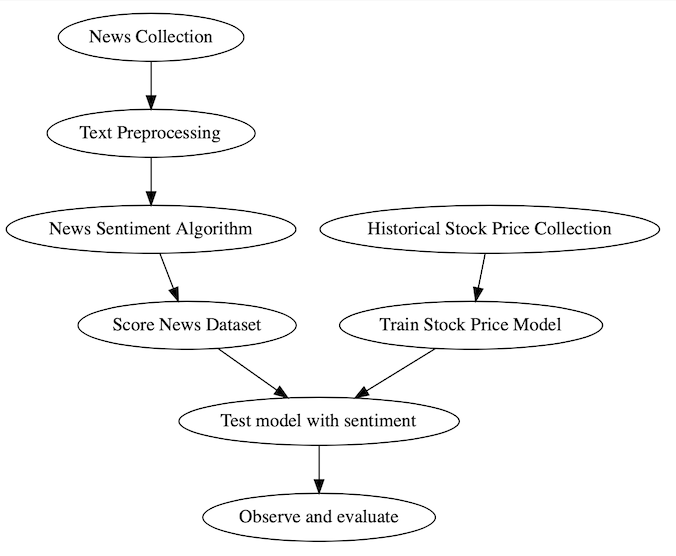

**Note**:
We are using Google Colab for this final report, so the code below enables us to access the module created in our GitHub Repository. This approach eliminates the need to upload the module directly to Colab. We also recommend that readers use Google Colab to run the project, especially due to the potential use of a GPU for calculations.

In [1]:
!rm -rf PIC16B---Project
!git clone https://github.com/srcontreras/PIC16B---Project.git
%ls PIC16B---Project
%cd PIC16B---Project
!git pull

Cloning into 'PIC16B---Project'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 577 (delta 19), reused 19 (delta 9), pack-reused 544
Receiving objects: 100% (577/577), 9.11 MiB | 19.16 MiB/s, done.
Resolving deltas: 100% (336/336), done.
articles.csv     fin_data.csv  negative_augmented_version.csv  README.md
final_score.csv  goodnews.py   ourProject/                     Starbucks_news.csv
/content/PIC16B---Project
Already up to date.


Now that we have access to the GitHub repository, ensure you have all the necessary packages for this project. The list of packages we used is provided below. If you don't have them installed, please run this code block before starting our project. The first two packages might be new to the Colab environment, so executing the first two lines should generally suffice. (There might be an error regarding to scikit-learn when you install the modules below and run import ourProject in the next code block. If that happens, restart the notebook, skip this code block, and go straight into import ourProject. It should be good by then)

```python
!pip install yahoo_fin
!pip install numpy requests nlpaug
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install matplotlib
!pip install nltk
!pip install plotly
!pip install -U scikit-learn
```


Once we have everything set up, we can begin our project. We will explain our functions and classes in detail to ensure readers fully understand what we have achieved and how we did it. First, let's import the packages we need for the remainder of the project. Below, you will find the file names, function names, and class names included in our module.

In [2]:
import ourProject
dir(ourProject)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['ModelPred',
 'TextDataPrep',
 'TrainModel',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'add_features',
 'clean_data',
 'compile_train',
 'create_data',
 'evaluate_model',
 'get_news',
 'get_wordnet_pos',
 'lemma',
 'make_dataset',
 'negative_aug',
 'plot_history',
 'pred_scores',
 'pred_target',
 'prepData',
 'remove_punc',
 'run_model',
 'scalers',
 'split_data',
 'starbucks_news',
 'stock_price_change',
 'stock_price_percentage',
 'stockprice',
 'train_val_test']

# **Technical Component 1:** *Find News Articles*
In this section, we will discuss how we find news articles about Starbucks, the company we want to make predictions on, as well as "positive" news articles that will serve as our training set. We utilize interactions with ***TheNewsAPI*** and apply ***web scraping*** techniques to acquire the desired news articles. The files we will use in this section are starbucks_news.py and goodnews.py. Let's focus first on starbucks_news.py, which explains how we interact with the API to extract news articles about Starbucks.

### **Starbucks News Article** (starbucks_news.py)
Before we begin, it's important to note a key aspect of interacting with TheNewsAPI: it is **NOT FREE**. The API token provided in this file is no longer valid. We advise anyone running our project **not** to execute the methods defined in the class in this Python file, except for ```understand_data(df)```, which generates plots. Instead, we have prepared the Starbucks_news.csv dataset, containing all the necessary textual information obtained from this API. We highly recommend directly reading this CSV file to understand the data we have collected. Despite this, we will still explain the contents and functionality of this Python file.

One can see that we have created a class in this Python file. This class is designed for retrieving Starbucks news articles, ranging from 2021-01-01 to 2023-11-14, by interacting with TheNewsAPI, as mentioned above. Data cleaning and visualization are also functionalities incorporated into this class.

The constructor function sets specific parameters for the news articles we consider: it filters articles related to Starbucks, spanning from 2021-01-01 to 2023-11-14. This range represents the largest span we could access at the time, given that the API maintains a history of 2 years, and our work on this component began on 2023-11-14. The API returns data in pages, each containing 25 news articles. Hence, we use the ```pages``` parameter to determine the number of pages we need to loop through. The api_token and conn parameters are used for accessing the API, and these are defined in the ```__main__``` function at the bottom of this file.

```python
class get_news:
  def __init__(self, company_name = 'Starbucks', end_date = '2023-11-14', pages = None,
                 api_token = None, conn = None):
        '''
        @param company_name: str, we only focus on news articles of this company; default Starbucks
        @param end_date: str, we only consider news articles up to this date; default 2023-11-14
        @param pages: int, the number of pages retrieved from the API; default None
        @param api_token: str, the api key for accessing the API; default None
        @param conn: object, the connector that allows to access the API; default None
        '''
```

The subsequent function is dedicated to interacting with the API and retrieving news articles about Starbucks. The code structure, though it may appear unusual initially, follows the correct format for accessing the API, as outlined in its documentation. After successfully extracting each page of news articles, we first convert the format of each page from JSON to a Python dictionary. Subsequently, these dictionaries are stored in a list, which comprises the raw data of the news articles we have gathered.

```python
def retrieve_raw_data(self):
        '''
        This method helps us collect news articles of Starbucks from the TheNewsAPI. We append each page
        from the API to a list, and use it as our raw data for future processes. No parameter is required:
        all necessary ones are defined in the constructor.
        
        @rvalue: list, the return value is a list that contains all pages of news articles of Starbucks.
        '''
```

Although we have a list containing all the pages of news articles, our goal is to store this information in a DataFrame, which can then be exported to .csv files for future operations. To facilitate this, we define a function that processes one feature of the news articles at a time. This function extracts a specific feature from each news article and stores it in a list, which can then be used as a column in the DataFrame.

The news articles encompass 7 features in total: "title", "description", "keywords", "url", "published_at", "source", and "categories". The function is designed to handle one feature at a time; therefore, we need to invoke this function 7 times within the main function, using a for loop. Each iteration adds the resulting list as a new column to the DataFrame. Consequently, the DataFrame will ultimately comprise 7 columns, with each column corresponding to one of the news article features. This process will become more evident when we examine the code.

```python
def element(self, raw_data, feature):
        '''
        This method collects one detail (feature) of the news article from the raw data we get from
        retrieve_raw_data() method. This can then be used as a column of a dataframe.
        
        @param raw_data: list, the raw data that contains all pages of the news articles;
        @feature: str, the specific feature of news articles.
        
        @rvalue: list, the return value is a list that contains the corresponding feature of each news article
                 in the raw data.
        '''
```

Once we have the DataFrame, it contains unprocessed data that needs to be cleaned for future use. To achieve this, we can utilize the function described below. This function truncates the date format to Year-Month-Day and sorts the table based on the date. As a result, we obtain a table organized chronologically, starting with the oldest news (2021-01-01) and concluding with the most recent news (2023-11-14).

```python
def clean(self, df):
        '''
        This method cleans the dataframe of Starbucks news articles, such as truncate the publish date of
        each article, clean the source, and sort the dataframe based on publish date, from oldest to latest.
        
        @param df: dataframe, each column of the dataframe is one feature of the news article, which is returned
                   by the element(raw_data, feature) method.
        
        @rvalue: dataframe, which is the cleaned version of the original df.
        '''
```

After completing these processes, we finally have a table containing Starbucks news articles dated from 2021-01-01 to 2023-11-14. The next function in our workflow is designed to visualize the data. It plots the number of news articles published each day and the number of days in a year with news coverage. Due to limitations of the API, there are some days for which we do not have any news articles. This absence of data can potentially affect the accuracy of our final predictions regarding Starbucks' stock prices. Consequently, understanding the yearly distribution of our news article data is crucial.

```python
def understand_data(self, df):
        '''
        This method visualizes the number of news articles on each day, along with the median of number of each year.
        This can help understand the distribution of our data, which can be used to make inference of the
        performance of prediction later.
        
        @param df: dataframe, the cleaned version of dataset, returned by clean(df).
        
        No return value, but show the plot.
        '''
```

### **Code Instruction**
Now we have explained every methods in this python file, let's see the code so that everything becomes clear. However, we have to mention again that the API token is **no longer valid**. Therefore, the code below is only for illustration purpose. You shouldn't run the code because it will cause an error. To see the final table and visualization, it's better to use the second code block. Read the code carefully. The comments should be enough for understanding this block.

```python
# settings of the TheNewsAPI
    api_token = "1XOrWumzd3Lw99zn156obKbYmWS9wtVw4FX4LiuS"
    conn = client.HTTPSConnection('api.thenewsapi.com')
    elements = ["title", "description", "keywords",
                "url", "published_at", "source", "categories"] # columns of the dataset
    df = pd.DataFrame() # table for news articles

    # use page = 1 to get the total number of news first
    # only when we have the total number of news, we could calculate
    # the number of pages, and then loop through each page for
    # retrieving all available news articles
    trial = ourProject.get_news("Starbucks", "2023-11-15", 1, api_token, conn) # initialize the class object
    trial_data = trial.retrieve_raw_data()
    news_number = int(trial_data[0]["meta"]['found']) # number of news articles
    
    # Each page contains 25 news articles, we want to calculate the total pages we have
    # so that we can loop through the number of pages.
    pages = news_number // 25
    if news_number % 25 != 0:
        pages += 1
    
    # now we know the number of pages, we call another class object with this number
    starbucks = ourProject.get_news("Starbucks", "2023-11-15", pages, api_token, conn)
    starbucks_data = starbucks.retrieve_raw_data()
    
    # create df columns, each column contains values of corresponding feature of news articles
    # for example, the column named title contains titles of news articles.
    for x in elements:
        ele = starbucks.element(starbucks_data, x)
        df[x] = ele
    
    clean_df = starbucks.clean(df) # clean the dataframe
    clean_df.to_csv("Starbucks_news.csv") # export to this .csv file.
```



As previously mentioned, it is more practical to directly read the CSV file we have created and visualize the data using this table. The next two code blocks demonstrate how to do this, along with the expected outcomes. The first code block shows how to import the table containing Starbucks news articles. As we can observe, this table comprises seven useful columns, each corresponding to a different feature of the news articles returned by the API. The table is organized by the date. For our model predictions, the column of primary interest will be the 'title' column, which encompasses all titles of the news articles.

In [3]:
import pandas as pd
starbucks = pd.read_csv("Starbucks_news.csv")
starbucks.head(5)

Unnamed: 0                                              title  \
0           0  [Targeted] Chase Offers/BofA: Save 10% at Star...   
1           1  IAC Stock Has Soared Through Spinoffs And Vime...   
2           2        ESG Flows Drive Clean Energy To Fresh Highs   
3           3  McDonald's will launch 3 chicken sandwiches ne...   
4           4  Starbucks (SBUX) Gains But Lags Market: What Y...   

                                         description  \
0  Check your Bank Amerideals for the following o...   
1  Barry Diller of IAC is set to reap great rewar...   
2  Stocks Analysis by Chris Vermeulen covering: S...   
3  McDonald's will launch three chicken sandwiche...   
4  In the latest trading session, Starbucks (SBUX...   

                                            keywords  \
0                                                NaN   
1  Jim Osman, The Edge, Vimeo, Barry Diller, IAC,...   
2                                                NaN   
3  Starbucks Corp, Restaurant Brands Internationa...   
4  stock, stocks, investment, investment advice, ...   

                                                 url               categories  \
0  https://www.doctorofcredit.com/bank-amerideals...   ['travel', 'business']   
1  https://www.forbes.com/sites/jimosman/2021/01/...  ['business', 'general']   
2  https://www.investing.com/analysis/esg-flows-d...             ['business']   
3  https://www.cnbc.com/2021/01/04/mcdonalds-will...  ['business', 'general']   
4  https://www.zacks.com/stock/news/1241554/starb...             ['business']   

         date           where  
0  2021-01-01  doctorofcredit  
1  2021-01-03          forbes  
2  2021-01-04       investing  
3  2021-01-04            cnbc  
4  2021-01-05           zacks

The second code block illustrates the number of news articles we have collected. From the resulting figure, it is evident that 2023 has the highest median number of news articles per day, while 2021 has the lowest. Furthermore, the data shows that 2023 includes 309 days with at least one news article, compared to only 267 days in 2021. These observations suggest that the quality and quantity of Starbucks news articles in 2021 are not as robust as in subsequent years. This limitation is due to the constraints of the API, and represents the best data we could obtain given our resources. For future studies, a larger dataset would undoubtedly be more beneficial for enhancing the accuracy and reliability of sentiment analysis tasks.

In [4]:
import plotly.io as pio
pio.renderers.default="iframe" # save the image
obj = ourProject.get_news() # we use default constructor in this case
obj.understand_data(starbucks)

### **Positive News Article** (goodnews.py)
This file is used for web scraping positive news articles from the website https://www.goodnewsnetwork.org/ , where all news articles are of positive sentiment. Since Starbucks is a business, we focus specifically on the business section of this website. The code includes a class essential for interaction with Scrapy. It comprises two methods: the first method (`parse`) calls the second method (`parse_title_content`) to parse the title and content of a news article. Once parsing of one page is complete, the parse method checks for the existence of a 'next' page, navigates to it, and continues parsing. This approach ensures that we can traverse through all available pages and extract all the required data.

To fully grasp the functionality of this file, it's beneficial to examine the file itself and read the comments and docstrings, which provide a deeper understanding of the operations being performed. The final table created by this file contains two columns: the title and the content of the news articles.

### **Code Instruction**

The code below explains in details how we web scrape the good news. Before doing this, make sure you have a valid conda environment and you install correctly the scrapy module. Once you have done all the preparations, we can dive into the details.

```python
conda activate your_environment
scrapy startproject your_project_name
```
This will create a project for scraping. Then, download the goodnews.py file from the GitHub repository, and put it in the spider folder. You can find this folder by:
your_project_name –> your_project_name –> spiders

Clearly, you need to know the directory of your project, i.e. where you created this project. It should be on the very top level

Then, go to the terminal, and type
```python
cd your_project_name
scrapy crawl goodnews -o results.csv
```

This will create a csv file named results, which contain the titles and contents of all good news articles. Then, you can see the table by
```python
df = pd.read_csv('directory_to_the_table')
```

However, you don't have to do all these processes, because to train our model, we have already created the table. You can directly read the ```articles.csv``` file in the GitHub repository by this the code block below, and the outcome is also shown.

In the next section, we will discuss how we preprocess the textual data and train the model. To create the train set, we use half of the table we created here. This balance the number of news articles between 'neutral' and 'positive' in the train set.

In [5]:
import pandas as pd
positive = pd.read_csv("articles.csv")
positive.head(5)

title  \
0  Butler University Creates 2-Year Debt-Free Col...   
1  Since Pandemic Closed His Business, New Jersey...   
2  PayPal Commits Over $500 Million to Support Mi...   
3  9-Year-Old and Friends Have Raised $100,000 fo...   
4  Hanes is Equipping America’s Homeless With 1 M...   

                                             content  
0  Butler University of Indianapolis has created ...  
1  The owner of a New Jersey frame shop has been ...  
2  PayPal yesterday announced a $530 million comm...  
3  Some unlikely heroes in Minneapolis have raise...  
4  Hanes basic apparel is not only encouraging Am...

# **Technical component 2:** *Preprocess the data and train the sentiment analysis model*
In this section, we will explore how to preprocess the data so that it can be fed into our model. We will also examine the accuracy and loss our model experienced after training for a few epochs. Using the final model, we will make predictions on Starbucks news articles to generate sentiment scores. These scores can then be combined with the pricing model to assess the overall impact of this factor.

This section is divided into two parts. In the first part, we explain the preprocessing of the data using various methods, such as lemmatization and data augmentation. Following that, we will train our model and use it to make predictions. Let's begin by looking at how to create a clean dataset that can be effectively utilized by the model.

### **Data Preprocessing** (TextDataPrep.py)
In order to create the sentiment analysis model, we create a training set with news articles and their sentiment in seperate columns. We used `fin_data.csv` which we retrieved from Kaggle, as part of the training data. The data from Kaggle had financial sentences in one column and their sentiment in another column. We combined this data with positive news articles we scraped from Good News Network to diversify our training data. The `TextDataPrep.py` defines `prepdata()` which takes in our two dataframes and merges them together; however the resulting dataframe only considers half of the data scraped from the Good News Network. This effectively helps balance the number of news articles between neutral and positive.

After defining the training data, we had to augment the negative flagged data because there were more neutral and positive sentiments recorded than negative. Without increasing the number in a reasonable way, the model will be biased towards neutral and positive sentiment. We used`nlpaug` module and `ContextualWordEmbsAug` and applied three different augmentation methods to the negative flagged data and saved it as `negative_augmented_version.csv` because the functions are slow when running. After that, we will do several cleaning processes, including removing punctuations and lemmatizing. Finally, we make a function that creates a dataset that could be accepted by TensorFlow. The model will then be trained on this dataset.

Let's first focus on how to merge the two tables to create the raw train table. The doc string should be detailed enough. The fin_data is the financial sentence table we have from Kaggle, and positive is the positive news articles table. They refer to ```fin_data.csv``` and ```articles.csv``` in GitHub. These two tables are passed as parameters to the function, so we need to define them before we call this function.

```python
def prepData(fin_data, positive, print_size = False):
    '''
    This function creates the dataframe that is for training the model. It has 2 parts: one is the 'fin_data' table
    and the other is the 'positive' table. We only take half of the 'positive' table to balance the "positive"
    sentiment and the "neutral" sentiment.
    
    @param fin_data: dataframe, contains financial sentences which are categorized into negative,
                     neutral and positive sentiments.
    @param positive: dataframe, contains all positive news articles by web scraping.
    @print_size: bool, if True, see how many texts we have for each sentiment;
                       if False, nothing happens; default is False
    
    @rvalue: dataframe, the raw dataframe for training purpose.
    '''
```

The next function is pivotal for augmenting the data related to negative news articles. In the absence of this process, our dataset would consist of only about 800 entries for negative sentiments, compared to over 3000 for both neutral and positive sentiments. Such an imbalance could lead to a significant bias towards the latter two categories. Indeed, when we initially attempted to predict Starbucks articles using a model trained without this augmented data, the predictions were predominantly 1 or 2, indicating a substantial bias. Therefore, this step is crucial for balancing our dataset.

We employ 2 different methods for augmenting the text:
1. Inserting neutral words such as 'usually' and 'even', which do not alter the original sentence's meaning.
2. Replacing words with their synonyms.

From these 2 ways, the number of negative sentences now increases to over 3000. Now we have a well balanced table.

It's important to note that this function operates quite slowly. Therefore, we do not recommend rerunning it. As with previous steps, we have already created and saved the augmented dataset, named ```negative_augmented_version.csv```. You can directly use this prepared dataset for further analysis.

```python
def negative_aug(df):
    '''
    ***** Note *****
    This function would be very slow. Therefore, instead of running it, we have a negative_augmented_version.csv
    file that contains augmented texts. It's better to read that file directly.
    ****************
    
    If we look at the number of texts for negative sentiment, which could be done by calling
    prepData(fin_data, positive, print_size = True), we may notice that it is much smaller than
    the other 2 sentiments. This might lead to bias in training. This function avoids this by adding
    data augmentation to negative sentences. 3 ways are used. After this, the numbers of texts for
    the 3 sentiments are similar.
    
    @param df: dataframe, the dataframe that is returned by function prepData(fin_data, positive, print_size)
    @rvalue: dataframe, augmented version.
    '''
```

However, it would be interesting to see what would happen after data augmentation. So we will just use 1 row of the table to check how the process has been done. The first line is the original sentence, while the next three are augmented version of this sentence. Notice that you may see some green bars below. This is because we have to download necessary materials from the nlpaug module.

In [6]:
import pandas as pd
data = pd.read_csv("fin_data.csv") # we know articles.csv only contains positive ones, so negative ones must come from fin_data.csv
neg_row = data[data['Sentiment'] == 'negative']
neg_row = neg_row.sample(frac=1)
neg_row = neg_row.iloc[:1]
augmented = ourProject.negative_aug(neg_row)
for i in augmented["Sentence"]:
  print(i)
  print('\n')

Operating profit totaled EUR 3.8 mn , down from EUR 4.5 mn in the corresponding period in 2005 .


operating net profit totaled eur 3. 1 8 bn mn, well down from approximately eur 4. 5 mn in the corresponding operational period started in october 2005.


operating profit totaled rs 7. 75 mn, down from another 4. 5 mn from its corresponding fiscal in 2008.


Operating profit represents EUR 5.8 billions, down from EN 4.5 billion during the corresponding month of 2005.




The next function is to remove the punctuation of a sentence, which is one data cleaning process. This function will be used with the vectorization layer in the model training part, but it is defined here because it is part of data preprocessing.

```python
def remove_punc(input_data):
    '''
    This function removes the punctuation in the text. This will be used in the TextVectorization layer of the model.
    
    @param input_data: tf str, the text data of our dataset.
    
    @rvalue: tf str, the text after removing punctuations.
    '''
```

The next two functions should be considered together, because they both serve the same purpose: lemmatizing the sentence. "Lemmatizing" means to transform the word to its basic or dictionary form, such as making plural to singular, comparative to basic and so on. This is important for the later model part, because when we vectorizing the sentence, we only consider the 3000 most frequent words. In this sense, it's important to ensure that we do not lose any important information. For example, ```continents``` and ```continent``` means the same thing for our model. However, because one is plural form and the other is singular form, the vectorization layer will treat them as two different words. If ```continent``` is a crucial word, so does ```continents```, but as our layer treats them differently, it might not be able to recognize the importance of the latter. We want to avoid this so that our model is accurate. The functions below help us achieve this goal.

```python
def get_wordnet_pos(treebank_tag):
    '''
    This function converts a Penn Treebank part-of-speech tag to a WordNet POS tag.
    This is part of the function defined next.
    
    @param treebank_tag: str, a part of speech tag in Penn Treebank format.
    
    @rvalues: str or None, the corresponding WordNet part-of-speech tag (one of ADJ, VERB, NOUN, ADV),
                           or None if the treebank tag doesn't satisfy some conditions.
    '''

def lemma(x):
    '''
    Lemmatize a sentence using NLTK's WordNetLemmatizer, converting each word to its base or dictionary form.
    This function tokenizes the input sentence, assigns part-of-speech tags, and then lemmatizes each word
    based on its POS tag. If a POS tag is not recognized, it defaults to NOUN.
    This function will be used with .apply() method.

    @param x: str, sentence in string format to be lemmatized.
    
    @rvalues: str, the lemmatized sentence, with each word in its base form.
    '''
```

Now, we have done all our data preprocessing and cleaning steps. We need to transform the data from a pandas dataframe to a tensor's dataset, so that our model could then take inputs and outputs from it. The function belows serves this purpose, and we do some further cleaning processes, such as removing stop words and transforming the words to lower cases.

```python
def make_dataset(df):
    '''
    This function transforms a pandas dataframe into a tensorflow dataset, with all the cleaning processes
    we defined above.
    
    @param df: dataframe, contains the news article
    
    @rvalues: tensorflow dataset, contains clean text data.
    '''
```

### **Code Instruction**
We have explained everything in this file, and in fact, we won't run this file, because it only serves as a preparation for the model training in the next sub-section. The most important function, `make_dataset()`, will actually be passed into the `TrainModel()` function defined in a different file. We will see full explanations in the next sub-section. We can certainly run the first two functions, `prepData` and `negative_aug`, but as mentioned, the latter function will be very slow. Therefore, we recommend you directly read the `negative_augmented_version.csv` file. This file will then be passed into the `TrainModel()` function, which we will discuss in a moment.

In [7]:
import pandas as pd
table = pd.read_csv("negative_augmented_version.csv")
table.head()

Unnamed: 0                                           Sentence Sentiment
0        1583  The sales of the Tiimari segment fell by 4.0 %...  negative
1        3053  With the U.S. Federal Government putting a sta...   neutral
2          66  Finnish GeoSentric 's net sales decreased to E...  negative
3        4472  In 2009 , Comptel slipped to a net loss of EUR...  negative
4        3471  The sellers were EOSS Innovationsmanagement an...   neutral

### **Model Training and Prediction** (ModelPred.py)
We have our dataset now, and it's time to train our model. Our text analysis model has the architecture like this:
```python
layers.Embedding(max_tokens, output_dim = 10, name="embedding"),
layers.Dropout(0.2),
layers.GlobalAveragePooling1D(),
layers.Dropout(0.2),
layers.Dense(3)
```
It's not a complex model, but it could generate around 73% accuracy in validation set, which is very high, considering our data size and quality. Besides defining the model, we do many things, such as sentiment labelling, tensorflow dataset creation, prediction set creation and so on. These ensure that our model will work just fine. We can see that the `make_dataset` and the `remove_punc` are functions we defined in the `TextDataPrep.py` file. Indeed, the purpose of that file is to prepare for this file. Notice that in this function, we not only transform the train table into tensorflow dataset, we also transform the prediction table, starbucks, into tensorflow dataset. By this, we don't need to write another function that focuses on the prediction dataset. Remember, as mentioned at the very beginning, we only consider titles of starbucks news articles. Therefore, it's highly recommended you to read the function carefully. All codes are fully explained by comments.

```python
def TrainModel(df, starbucks, make_dataset, remove_punc):
    '''
    This function trains the model on the textual dataframe we have. The function will return the model
    so that it could be used for prediction on the Starbucks news dataframe for sentiment analysis.
    It will also return the prediction dataset
    
    @param df: dataframe, the train data we have which will be used to create Tensor's dataset;
    @param starbucks: dataframe, contains news articles of Starbucks; we create the tensor's dataset for
                      it in the same way as df;
    @param make_dataset: func, function for creating Tensor's dataset, defined in TextDataPrep.py;
    @param remove_punc: func, function for removing punctuations, defined in TextDataPrep.py.
    
    @rvalue: model after training, which will be used for prediction;
             the prediction dataset we will use for prediction
    '''
```

After training the model, we can finally predict the sentiment scores on each day of Starbucks. This requires some work, because as mentioned, we don't have news articles on all days: there are missing dates. Sometimes on one day we have news articles but no stock price, and sometimes vice versa. In this sense, we need to be careful about the misalignment of dates for the stock price and for the news articles. Again, it's better to look at the comments and docstrings in the function.

```python
def pred_scores(model, real, starbucks, check = False):
    '''
    This function finally creates the prediction score on each day and returns it,
    so that it could be used to predict stock price change.
    We should be careful that the date of the news article and the date of stock price are not aligned:
    sometimes on one day we have news articles but no stock price, sometimes vice versa.
    We need to handle this.
    
    @param model: model that is used for prediction, returned by function TrainModel;
    @param real: the prediction dataset we have, returned by function TrainModel;
    @param starbucks: dataframe, contains news articles of starbucks;
    @check: bool, check accuracy of our prediction; If True, print out 5 predictions; Else, nothing happens
    
    @rvalue: list, the final aligned sentiment score on each day that could be used for price prediction.
    '''
```

### **Code Instruction**
We first need to train the model, and we can see the history of training and a figure that illustrates the change of losses for train and validation set over number of epochs. We can see that there is some overfitting problem, but it's not very serious. Given the dataset we have, this around 10% overfitting is acceptable. When we run this code block in the colab notebook, we get a validation accuracy about 72%, which meets our expectation. The accuracy for test set is around 74%, aligns with the validation accuracy. This means that there is little overfitting problem. Again, given our dataset, this accuracy is useful, and we will accept this model. We will then use this model to predict the sentiment scores of Starbucks news articles.

Epoch 1/10
6765/6765 [==============================] - 34s 5ms/step - loss: 1.0416 - accuracy: 0.4993 - val_loss: 0.9596 - val_accuracy: 0.5815
Epoch 2/10
6765/6765 [==============================] - 27s 4ms/step - loss: 0.8600 - accuracy: 0.6605 - val_loss: 0.8009 - val_accuracy: 0.6653
Epoch 3/10
6765/6765 [==============================] - 26s 4ms/step - loss: 0.7044 - accuracy: 0.7289 - val_loss: 0.7063 - val_accuracy: 0.6963
Epoch 4/10
6765/6765 [==============================] - 27s 4ms/step - loss: 0.6095 - accuracy: 0.7659 - val_loss: 0.6638 - val_accuracy: 0.7144
Epoch 5/10
6765/6765 [==============================] - 25s 4ms/step - loss: 0.5498 - accuracy: 0.7849 - val_loss: 0.6453 - val_accuracy: 0.7268
Epoch 6/10
6765/6765 [==============================] - 27s 4ms/step - loss: 0.5105 - accuracy: 0.7991 - val_loss: 0.6367 - val_accuracy: 0.7268
Epoch 7/10
6765/6765 [==============================] - 27s 4ms/step - loss: 0.4770 - accuracy: 0.8087 - val_loss: 0.6369 - val_ac

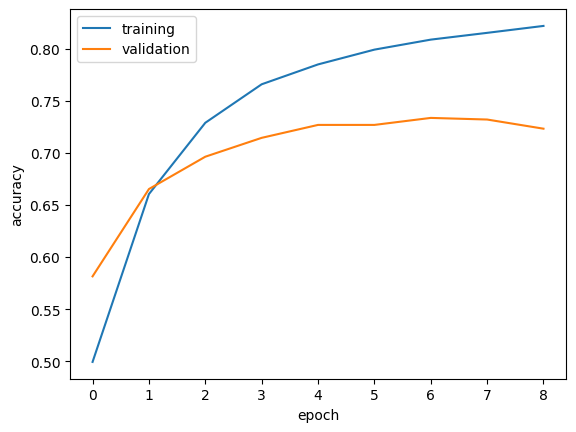

In [8]:
import pandas as pd
data = pd.read_csv("negative_augmented_version.csv")
sbux = pd.read_csv("Starbucks_news.csv")
model, pred = ourProject.TrainModel(data, sbux, ourProject.make_dataset, ourProject.remove_punc)

Finally, we can predict the scores by the model, and we can see the prediction scores we have on each day. The difficult part of this function is the part of handling misalighment of dates of two dataframes. Therefore, make sure you understand this part by reading the docstrings and comments. We can see that our model predicts about xxx number of negative sentiments, xxx neutral ones, and xxx positive ones. Remember 0 stands for negative, 1 stands for neutral, and 2 stands for positive. And by looking at the original sentences and the predicted sentiment of that sentence, we can see that the performance of our model is not bad. In fact, it's quite accurate. We also saved the results in ```final_score.csv```. Reading directly from this table is an alternative way, but it's  a recommended one to consider, because our pricing model uses the data in the csv file, but not the result generated here. The function used in the next section will use the score table, so without changing the code behind scene, we recommend you to read scores from the table.

In [9]:
final_score = ourProject.pred_scores(model, pred, sbux, True) # this will print some sentences with scores, to check prediction accuracy

7488/7488 [==============================] - 15s 2ms/step
" [Targeted] Chase Offers/BofA: Save 10% at Starbucks, up to $3 Cashback " scores:  0


" IAC Stock Has Soared Through Spinoffs And Vimeo Is Next. Here’s Why You Should Take A Look. " scores:  2


" ESG Flows Drive Clean Energy To Fresh Highs " scores:  2


" McDonald's will launch 3 chicken sandwiches next month as it doubles down on chicken " scores:  2


" Starbucks (SBUX) Gains But Lags Market: What You Should Know " scores:  0




In [10]:
final_score2 = pd.read_csv("final_score.csv") # we recommend to use this alternative way
final_score2 = final_score2["Score"].to_numpy()

# **Technical component 3:**  *Stock price predicting*

We started the stock price model by downloading the stock price information for Starbucks using the `yahoo_fin` package. We downloaded data from 2021-01-04 to 2023-11-14 because the Starbucks news we had scraped only included news articles for that time period, meaning we had a total of 722 days of data. We created a `clean_data()` function to remove NAs from our dataset. The `add_features()` functions adds multiple columns to the stock price data such as: the difference of open and close columns, difference of low and high columns, a quarterly reports column that identifies months when quartery earning reports are released, estimated moving average with a window of 100 days, and columns for bollinger bands. It is important to add these features to the stock price data as it gives us more predictor variables to input into our model to test which features give us the lowest loss. The function `pred_target()` splits the data so that the features columns are the predictors and the closing price column is the target data. The `scalers()` function defines scalers for both the predictor and target data, and then utilizes those scalers to normalize the data. After standardizing our datasets, we split the data into testing, validation and training sets, and furthermore split those datasets into inputs and outputs using the functions `train_val_test()` and `split_data()`.

The following code is the outline for our stock price model:
```python
final_dense = len(features) # define output for dense layer
model = Sequential()
output_shape = x_train.shape[1] * x_train.shape[2]
model.add(LSTM(output_shape, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(output_shape, return_sequences=False))
model.add(Dense(final_dense))
model.add(Dense(1))
```
For our model, we used Long-Short-Term Memory layers because they are great for long term dependencies which is key in our model because we are using previous stock data to predict the next stock price. In our model, we are also using two Dense layer with the first Dense layer having the length of the features variable as the number of neurons so that the model does not run into issues when defining metrics.

Once we create our Sequential model using Long Short Term Memory and Dense layers, we create a function to compile the model using mean squared error as the loss function, and train the model using training data, validation data, and the `EarlyStopping` callback. The function `plot_history()` visualizes the loss for each epoch for the training and validation data, and the `evaluate_model()` function calculates the mean absolute error, mean absolute percentage error, and median absolute percentage error for the actual and predicted closing values and produces a plot to visualize the actual and predicted closing values.

There are many functions used to create the model, therefore we consolidated all the functions within `run_model()` so that only one function is needed to run the model. In this sense, we recommend you to read carefully the docstrings and comments written for each function, so that you understand what the `run_model()` includes. In the following code, we are running the model **without** taking into account the sentiment scores for the Starbucks news articles.

In [5]:
import plotly.io as pio
pio.renderers.default="iframe"
stock_data = ourProject.create_data()
features = ["close", "open", "bollinger_upper", "bollinger_lower", "ema100"]
model, x_test, y_test, target = ourProject.run_model(stock_data, sentiment_df = None, features = features)

Epoch 1/50
23/23 [==============================] - 6s 49ms/step - loss: 0.0257 - val_loss: 0.0149
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0056
Epoch 4/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 5/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0035 - val_loss: 0.0069
Epoch 7/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 9/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 10/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 11/

In [6]:
ourProject.evaluate_model(model, x_test, y_test, target)

7/7 [==============================] - 1s 7ms/step


Mean Absolute Error (MAE): 1.63
Mean Absolute Percentage Error (MAPE): 1.61 %
Median Absolute Percentage Error (MDAPE): 1.43 %


From this output, we see that there is litte overfitting since the training loss is not that much higher than the validation loss. The MAE tells us that on average, the model's predicted closing price is off by $2.07. The MAPE tells us that on average the percentage difference between the actual and predicted closing prices is 2.07%. The MDAPE is 1.66% which means that about half of the models predicted closing prices deviate by at most 1.66% from the actual closing prices. All of these metrics let us know that the model performs well since the metrics are low.

Now let's put the sentiment scores we have into consideration.

In [7]:
import plotly.io as pio
import pandas as pd
pio.renderers.default="iframe"
stock_data = ourProject.create_data()
sentiment = pd.read_csv("final_score.csv")
model2, x_test2, y_test2, target2 = ourProject.run_model(stock_data, sentiment_df = sentiment, features = features)

Epoch 1/50
23/23 [==============================] - 5s 47ms/step - loss: 0.0375 - val_loss: 0.0068
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 5/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 8/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 9/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 10/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 11/50

In [8]:
ourProject.evaluate_model(model2, x_test2, y_test2, target2)

7/7 [==============================] - 1s 6ms/step


Mean Absolute Error (MAE): 1.29
Mean Absolute Percentage Error (MAPE): 1.28 %
Median Absolute Percentage Error (MDAPE): 0.99 %


From this output, we see that there is some overfitting since the training loss is a bit higher than the validation loss, but they are relatively close to each other. The MAE tells us that on average, the model's predicted closing price is off by $1.37. The MAPE, tells us that on average the percentage difference between the actual and predicted closing prices is 1.34%. The MDAPE is 1.18% which means that about half of the models predicted closing prices deviate by at most 1.18% from the actual closing prices. Since these metrics are low, our model performed well, but it doesn't outperforms the original model without the sentiment data.

We can see from the history and metrics that the loss is higher for the model that used sentiment scores as a predictor. From this we can conclude that using sentiment from news articles does help improve the accuracy for our stock price model. This is good, because it shows that how a company is perceived and talked about in the media, does relate to how it's stock price is doing. This follows our expectation. However, the testing scores we get is not stable: sometimes the model with sentiment is better, while sometimes not. This might be due to the dataset we have. We believe that with a higher quality and quantity of data, we could achieve a better result: outperforming the model without sentiment score. However, the sentimental score is still a good factor, beacuse it doesn't 'destory' the model. Still, this is an important tool for investors and for the company because it lets investors know to look out for a company's reputation when deciding their position in stock, and it let's the company know that perception of their company is important for their stock price.

# **Concluding remarks**

We recognize that this project encompasses three crucial components: data sourcing, data preprocessing, and data prediction. Each of these tasks was challenging in its own right, so we are quite satisfied with the results we have achieved, and we hope you, the readers, will also appreciate our efforts.

Overall, this project was somewhat successful in achieving what we set out to do. Our limited access to a larger database of news articles from APIs such as newsdata.api or newsdata.io did constrain the extent of sentiment analysis we could perform and impacted the quality of the articles we obtained. Nonetheless, what we have as our final product is the culmination of our best efforts in a somewhat challenging situation. We worked diligently to overcome obstacles encountered in model creation and dataset preparation, ultimately producing an accurate model that we take great pride in. Our approach not only utilized tools taught in class but also integrated advanced techniques such as recurrent neural networks and web scraping, thereby enhancing our model beyond the course's scope. Looking ahead, we aspire to expand our model to include more companies and a larger corpus of news articles. We also plan to draw upon existing research papers and projects related to ours, learning from their insights to further refine our models.

Unlike analyses that rely on public sentiments from sources like Twitter reviews or comments, our project is based on public news articles, which are meticulously written and edited. Assuming these articles are factual and objective, significant ethical concerns, especially compared to using personal reviews, are minimized. It's important to note that our project is intended solely for educational purposes, and we do not hold responsibility for any potential investment losses. Thus, for those who wish to learn from our project, it should be perfectly suitable.